![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2F02+-+Vertex+AI+AutoML&file=02c+-+Vertex+AI+%3E+Pipelines+-+AutoML+with+clients+%28code%29+In+automated+pipeline.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/02%20-%20Vertex%20AI%20AutoML/02c%20-%20Vertex%20AI%20%3E%20Pipelines%20-%20AutoML%20with%20clients%20%28code%29%20In%20automated%20pipeline.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2F02%2520-%2520Vertex%2520AI%2520AutoML%2F02c%2520-%2520Vertex%2520AI%2520%253E%2520Pipelines%2520-%2520AutoML%2520with%2520clients%2520%2528code%2529%2520In%2520automated%2520pipeline.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/02%20-%20Vertex%20AI%20AutoML/02c%20-%20Vertex%20AI%20%3E%20Pipelines%20-%20AutoML%20with%20clients%20%28code%29%20In%20automated%20pipeline.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/02%20-%20Vertex%20AI%20AutoML/02c%20-%20Vertex%20AI%20%3E%20Pipelines%20-%20AutoML%20with%20clients%20%28code%29%20In%20automated%20pipeline.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

# 02c - Vertex AI > Pipelines - AutoML with clients (code) In automated pipeline

Use[ Kubeflow](https://www.kubeflow.org/) Pipelines running on [Vertex AI Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines/introduction) to orchestrate the process of training a custom model with AutoML Tabular and deploy it to a Vertex AI Endpoint for serving (online and batch) predictions and explanations.  This demonstrates how to automate the processes of (02a) or (02b) with pipeline orchestration.

### Video Walkthrough of this notebook:
Includes conversational walkthrough and more explanatory information than the notebook:
<p align="center" width="100%"><center><a href="https://youtu.be/1gHJgY7AXAs" target="_blank" rel="noopener noreferrer"><img src="../architectures/thumbnails/playbutton/02c.png" width="40%"></a></center></p>

Notes Since Video:
- update notebook on 8/31/2022 to:
    - make the pipeline run with input parameters rather than using local variable in the pipeline definition
    - update the model evaluation section to show update Python Client methods for metric retrieval

### Prerequisites:
-  01 -  BigQuery - Table Data Source

### Resources:
-  [Vertex AI Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines/build-pipeline#google-cloud-components) see aiplatform.PipelineJob
-  [Python Client for Vertex AI](https://googleapis.dev/python/aiplatform/latest/aiplatform.html)
-  [Kubeflow Pipelines Components for Google Cloud](https://github.com/kubeflow/pipelines/tree/master/components/google-cloud)

### Related Training:
-  Codelab: [Vertex AI Pipelines Introduction](https://codelabs.developers.google.com/vertex-mlmd-pipelines#0)

### Conceptual Flow & Workflow
<p align="center">
  <img alt="Conceptual Flow" src="../architectures/slides/02c_arch.png" width="45%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img alt="Workflow" src="../architectures/slides/02c_console.png" width="45%">
</p>

---
## Setup

inputs:

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [2]:
REGION = 'us-central1'
DATANAME = 'fraud'
NOTEBOOK = '02c'

# Resources
DEPLOY_COMPUTE = 'n1-standard-2'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id' # add more variables to the string with space delimiters

packages:

In [3]:
#!pip install -U google-cloud-pipeline-components -U -q

In [22]:
from google.cloud import aiplatform
from datetime import datetime
import kfp
from kfp.v2 import compiler
#import kfp.v2.dsl as dsl
#import google_cloud_pipeline_components as gcc_aip
from google_cloud_pipeline_components.v1.dataset import TabularDatasetCreateOp
from google_cloud_pipeline_components.v1.automl.training_job import AutoMLTabularTrainingJobRunOp
from google_cloud_pipeline_components.v1.endpoint import EndpointCreateOp, ModelDeployOp

from google.cloud import bigquery
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
import json
import numpy as np

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The module `kfp.v2` is deprecated and will be removed in a futureversion. Please import directly from the `kfp` namespace, instead of `kfp.v2`.
  after removing the cwd from sys.path.


clients:

In [15]:
aiplatform.init(project=PROJECT_ID, location=REGION)
bq = bigquery.Client()

parameters:

In [16]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET = PROJECT_ID
URI = f"gs://{BUCKET}/{DATANAME}/models/{NOTEBOOK}"
DIR = f"temp/{NOTEBOOK}"

In [17]:
SERVICE_ACCOUNT = !gcloud config list --format='value(core.account)' 
SERVICE_ACCOUNT = SERVICE_ACCOUNT[0]
SERVICE_ACCOUNT

'1026793852137-compute@developer.gserviceaccount.com'

List the service accounts current roles:

In [18]:
!gcloud projects get-iam-policy $PROJECT_ID --filter="bindings.members:$SERVICE_ACCOUNT" --format='table(bindings.role)' --flatten="bindings[].members"

ROLE
roles/bigquery.admin
roles/owner
roles/run.admin
roles/storage.objectAdmin


>Note: If the resulting list is missing [roles/storage.objectAdmin](https://cloud.google.com/storage/docs/access-control/iam-roles) then [revisit the setup notebook](../00%20-%20Setup/00%20-%20Environment%20Setup.ipynb#permissions) and add this permission to the service account with the provided instructions.

environment:

In [19]:
!rm -rf {DIR}
!mkdir -p {DIR}

---
## Pipeline (KFP) Definition
- Flow
    - Create Vertex AI Dataset from link to BigQuery table
    - Create Vertex AI AutoML Tabular Training Job
    - Create Endpoint and Depoy trained model
    
Use [AI Platform Pipeline Components](https://google-cloud-pipeline-components.readthedocs.io/en/google-cloud-pipeline-components-0.2.0/)
- Specifically, [AutoMLTabularTrainingJobRunOp](https://google-cloud-pipeline-components.readthedocs.io/en/google-cloud-pipeline-components-0.2.0/google_cloud_pipeline_components.aiplatform.html#google_cloud_pipeline_components.aiplatform.AutoMLTabularTrainingJobRunOp)

Define a Job:
- Consider Weighting
- Model Type
- Optimization Objective

In [20]:
@kfp.dsl.pipeline(
    name = f'kfp-{NOTEBOOK}-{DATANAME}-{TIMESTAMP}',
    pipeline_root = URI+'/'+str(TIMESTAMP)+'/kfp/'
)
def pipeline(
    project: str,
    dataname: str,
    display_name: str,
    deploy_machine: str,
    bq_source: str,
    var_target: str,
    var_omit: str,
    features: dict,
    labels: dict 
):
    
    # dataset
    dataset = TabularDatasetCreateOp(
        project = project,
        display_name = display_name,
        bq_source = bq_source,
        labels = labels
    )
    
    # training
    model = AutoMLTabularTrainingJobRunOp(
        project = project,
        display_name = display_name,
        optimization_prediction_type = "classification",
        optimization_objective = "maximize-au-prc",
        budget_milli_node_hours = 1000,
        disable_early_stopping=False,
        column_specs = features,
        dataset = dataset.outputs['dataset'],
        target_column = var_target,
        predefined_split_column_name = 'splits',
        labels = labels
    )
    
    # Endpoint: Creation
    endpoint = EndpointCreateOp(
        project = project,
        display_name = display_name,
        labels = labels
    )
    
    # Endpoint: Deployment of Model
    deployment = ModelDeployOp(
        model = model.outputs["model"],
        endpoint = endpoint.outputs["endpoint"],
        dedicated_resources_min_replica_count = 1,
        dedicated_resources_max_replica_count = 1,
        traffic_split = {"0": 100},
        dedicated_resources_machine_type= deploy_machine
    )

---
## Compile Pipeline

In [23]:
compiler.Compiler().compile(
    pipeline_func = pipeline,
    package_path = f"{DIR}/{NOTEBOOK}.json"
)

Move compiled pipeline files to GCS Bucket

In [24]:
!gsutil cp {DIR}/{NOTEBOOK}.json {URI}/{TIMESTAMP}/kfp/

Copying file://temp/02c/02c.json [Content-Type=application/json]...
/ [1 files][ 46.9 KiB/ 46.9 KiB]                                                
Operation completed over 1 objects/46.9 KiB.                                     


---
## Create Vertex AI Pipeline Job

Get features dictionary for the pipeline input:

In [25]:
# get feature names
query = f"SELECT * FROM {DATANAME}.INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = '{DATANAME}_prepped'"
schema = bq.query(query).to_dataframe()
OMIT = VAR_OMIT.split() + [VAR_TARGET, 'splits']
features = schema[~schema.column_name.isin(OMIT)].column_name.tolist()
features = dict.fromkeys(features, 'auto')

Run The pipeline:

In [26]:
pipeline = aiplatform.PipelineJob(
    display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    template_path = f"{URI}/{TIMESTAMP}/kfp/{NOTEBOOK}.json",
    parameter_values = {
        "project" : PROJECT_ID,
        "dataname" : DATANAME,
        "display_name" : f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
        "deploy_machine" : DEPLOY_COMPUTE,
        "bq_source" : f'bq://{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped',
        "var_target" : VAR_TARGET,
        "var_omit" : VAR_OMIT,
        "features" : features,
        "labels" : {'notebook': NOTEBOOK}       
    },
    labels = {'notebook': NOTEBOOK},
    enable_caching=False
)

In [ ]:
response = pipeline.run(
    service_account = SERVICE_ACCOUNT
)

Creating PipelineJob
PipelineJob created. Resource name: projects/1026793852137/locations/us-central1/pipelineJobs/kfp-02c-fraud-20230825120638-20230825120849
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/1026793852137/locations/us-central1/pipelineJobs/kfp-02c-fraud-20230825120638-20230825120849')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/kfp-02c-fraud-20230825120638-20230825120849?project=1026793852137
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/kfp-02c-fraud-20230825120638-20230825120849 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/kfp-02c-fraud-20230825120638-20230825120849 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/kfp-02c-fraud-20230825120638-20230825120849 current state:
PipelineState.PIPELINE_S

Visual Representation of the pipeline can be viewed in the colsole:

In [30]:
print(f"Review the Pipeline as it runs here:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/pipelines/runs/{pipeline.resource_name.split('/')[-1]}?project={PROJECT_ID}")

Review the Pipeline as it runs here:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/kfp-02c-fraud-20230825120638-20230825120849?project=statmike-mlops-349915


Retrieve the pipeline information:

In [31]:
aiplatform.get_pipeline_df(pipeline = f'kfp-{NOTEBOOK}-{DATANAME}-{TIMESTAMP}')

,pipeline_name,run_name,param.input:labels,param.input:project,param.input:display_name,param.input:bq_source,param.input:var_omit,param.input:var_target,param.input:deploy_machine,param.input:features,param.input:dataname
0,kfp-02c-fraud-20230825120638,kfp-02c-fraud-20230825120638-20230825120849,{'notebook': '02c'},statmike-mlops-349915,02c_fraud_20230825120638,bq://statmike-mlops-349915.fraud.fraud_prepped,transaction_id,Class,n1-standard-2,"{'V5': 'auto', 'V28': 'auto', 'Amount': 'auto'...",fraud


---
## Evaluation
While the model above was trained using AutoML with the API, it is still possible to review the evaluation metrics directly in the Google Cloud Console.  Just visit the Models section of Vertex AI service and select the model and it will present the evaluation metrics with many helpful visuals.

It is also possible to retrieve the evaluation metrics for you model using the API.  This section shows how to use the API.

<p align="center" width="100%"><center><a href="https://youtu.be/m_x3WBtr6y0" target="_blank" rel="noopener noreferrer"><img src="../architectures/thumbnails/playbutton/02c.png" width="40%"></a></center></p>
<p align="center" width="100%"><center>Part 2 Video</center></p>

Notes Since Video:
- update notebook on 8/31/2022 to:
    - make the pipeline run with input parameters rather than using local variable in the pipeline definition
    - update the model evaluation section to show update Python Client methods for metric retrieval

For more information review [this page](https://cloud.google.com/vertex-ai/docs/training/evaluating-automl-models).

Get the Model:

In [32]:
models = aiplatform.Model.list(filter=f'labels.notebook={NOTEBOOK}')

In [33]:
model = models[0]
model.resource_name

'projects/1026793852137/locations/us-central1/models/3955644813528793088'

Retrives the aggregate model evalution metrics for the model as a whole.  

Either:
- First, use `model.list_model_evaluations()` to retrieve the evaluation id, then use `model.get_model_evaluation(evaluation_id = )` for the evaluation id
- Or, use `.get_model_evaluation()` and it will retrieve the first model evaluation

In [34]:
evaluation = model.get_model_evaluation().to_dict() # get first evaluation

In [35]:
evaluation.keys()

dict_keys(['name', 'metricsSchemaUri', 'metrics', 'createTime', 'sliceDimensions', 'modelExplanation'])

In [36]:
evaluation['metrics'].keys()

dict_keys(['confusionMatrix', 'confidenceMetrics', 'auPrc', 'auRoc', 'logLoss'])

In [37]:
evaluation['metrics']['auPrc']

0.9997687

In [38]:
evaluation['metrics']['confidenceMetrics'][3]

{'trueNegativeCount': '28387',
 'falseNegativeCount': '5',
 'falsePositiveRateAt1': 0.00042102308,
 'falsePositiveRate': 0.0040348046,
 'precision': 0.9959807,
 'confidenceThreshold': 0.01,
 'recall': 0.9998246,
 'f1Score': 0.99789894,
 'f1ScoreAt1': 0.99957895,
 'truePositiveCount': '28497',
 'confusionMatrix': {'annotationSpecs': [{'displayName': '0', 'id': '0'},
   {'id': '1', 'displayName': '1'}],
  'rows': [[28454.0, 1.0], [11.0, 36.0]]},
 'f1ScoreMacro': 0.74111587,
 'recallAt1': 0.99957895,
 'falsePositiveCount': '115',
 'precisionAt1': 0.99957895,
 'f1ScoreMicro': 0.99789894}

Review several of the metrics included in the evaluation.  Also, compare these to the results in the console view.

In [39]:
print(f"Review this model in the console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/{model.name}/versions/{model.version_id}/evaluations/{evaluation['name'].split('/')[-1]}?project={PROJECT_ID}")

Review this model in the console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/3955644813528793088/versions/1/evaluations/5574753723182965420?project=statmike-mlops-349915


In [40]:
evaluation['metrics']['auPrc']

0.9997687

In [41]:
for i in range(len(evaluation['metrics']['confusionMatrix']['annotationSpecs'])):
    print('True Label = ', evaluation['metrics']['confusionMatrix']['annotationSpecs'][i]['displayName'], ' has Predicted labels = ', evaluation['metrics']['confusionMatrix']['rows'][i])

True Label =  0  has Predicted labels =  [28454.0, 1.0]
True Label =  1  has Predicted labels =  [11.0, 36.0]


For models with labels you can retrieve the evaluation metrics for each slice of the model as well using the .gapic api version:

In [42]:
model_client = aiplatform.gapic.ModelServiceClient(
    client_options = {
        'api_endpoint' : f'{REGION}-aiplatform.googleapis.com'
    }
)

In [43]:
slices = model_client.list_model_evaluation_slices(parent = evaluation['name'])

In [44]:
for slice in slices:
    print('Label = ', slice.slice_.value, 'has auPrc = ', slice.metrics['auPrc'])

Label =  1 has auPrc =  0.86363876
Label =  0 has auPrc =  0.9998231


---
## Prediction

### Prepare a record for prediction: instance and parameters lists

In [45]:
pred = bq.query(
    query = f"""
        SELECT * EXCEPT({VAR_TARGET}, splits, {VAR_OMIT})
        FROM {DATANAME}.{DATANAME}_prepped
        WHERE splits='TEST'
        LIMIT 10
    """
).to_dataframe()

In [46]:
pred.head(4)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,35337,1.092844,-0.013230,1.359829,2.731537,-0.707357,0.873837,-0.796130,0.437707,0.396770,...,-0.240428,0.037603,0.380026,-0.167647,0.027557,0.592115,0.219695,0.036970,0.010984,0.0
1,60481,1.238973,0.035226,0.063003,0.641406,-0.260893,-0.580097,0.049938,-0.034733,0.405932,...,-0.265080,-0.060003,-0.053585,-0.057718,0.104983,0.537987,0.589563,-0.046207,-0.006212,0.0
2,139587,1.870539,0.211079,0.224457,3.889486,-0.380177,0.249799,-0.577133,0.179189,-0.120462,...,-0.374356,0.196006,0.656552,0.180776,-0.060226,-0.228979,0.080827,0.009868,-0.036997,0.0
3,162908,-3.368339,-1.980442,0.153645,-0.159795,3.847169,-3.516873,-1.209398,-0.292122,0.760543,...,-0.923275,-0.545992,-0.252324,-1.171627,0.214333,-0.159652,-0.060883,1.294977,0.120503,0.0


In [47]:
pred['Time'] = pred['Time'].astype(str)
newobs = pred.to_dict(orient='records')
newobs[0]

{'Time': '35337',
 'V1': 1.0928441854981998,
 'V2': -0.0132303486713432,
 'V3': 1.35982868199426,
 'V4': 2.7315370965921004,
 'V5': -0.707357349219652,
 'V6': 0.8738370029866129,
 'V7': -0.7961301510622031,
 'V8': 0.437706509544851,
 'V9': 0.39676985012996396,
 'V10': 0.587438102569443,
 'V11': -0.14979756231827498,
 'V12': 0.29514781622888103,
 'V13': -1.30382621882143,
 'V14': -0.31782283120234495,
 'V15': -2.03673231037199,
 'V16': 0.376090905274179,
 'V17': -0.30040350116459497,
 'V18': 0.433799615590844,
 'V19': -0.145082264348681,
 'V20': -0.240427548108996,
 'V21': 0.0376030733329398,
 'V22': 0.38002620963091405,
 'V23': -0.16764742731151097,
 'V24': 0.0275573495476881,
 'V25': 0.59211469704354,
 'V26': 0.219695164116351,
 'V27': 0.0369695108704894,
 'V28': 0.010984441006191,
 'Amount': 0.0}

Need to understand the format of variables that the predictions expect.  AutoML may convert the type of some variables. The following cells retrieve the model from the endpoint and its schemata:

In [48]:
instances = [json_format.ParseDict(newob, Value()) for newob in newobs]

### Get Predictions: Python Client

In [49]:
aiplatform.Endpoint.list(filter=f'labels.notebook={NOTEBOOK}')

 resource name: projects/1026793852137/locations/us-central1/endpoints/7339602954241966080]

In [50]:
endpoint = aiplatform.Endpoint.list(filter=f'labels.notebook={NOTEBOOK}')[0]
endpoint.display_name

'02c_fraud_20230825120638'

In [51]:
prediction = endpoint.predict(instances = instances) # or instances = newobs
prediction.predictions[0]

{'classes': ['0', '1'], 'scores': [0.9979369640350342, 0.002062972635030746]}

In [52]:
prediction.predictions[0]['classes'][np.argmax(prediction.predictions[0]['scores'])]

'0'

### Get Predictions: REST

In [53]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps({"instances": [newobs[0]]}))

In [54]:
!curl -X POST \
-H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
-H "Content-Type: application/json; charset=utf-8" \
-d @{DIR}/request.json \
https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:predict

{
  "predictions": [
    {
      "scores": [
        0.99793696403503418,
        0.002062972635030746
      ],
      "classes": [
        "0",
        "1"
      ]
    }
  ],
  "deployedModelId": "8935011918330986496",
  "model": "projects/1026793852137/locations/us-central1/models/3955644813528793088",
  "modelDisplayName": "02c_fraud_20230825120638",
  "modelVersionId": "1"
}


### Get Predictions: gcloud (CLI)

In [55]:
!gcloud beta ai endpoints predict {endpoint.name.rsplit('/',1)[-1]} --region={REGION} --json-request={DIR}/request.json

Using endpoint [https://us-central1-prediction-aiplatform.googleapis.com/]
[{'classes': ['0', '1'], 'scores': [0.9979369640350342, 0.002062972635030746]}]


---
## Explanations
Interpretation Guide
- https://cloud.google.com/vertex-ai/docs/predictions/interpreting-results-automl#tabular

In [ ]:
explanation = endpoint.explain(instances = instances)

In [ ]:
explanation.predictions[0]

In [136]:
print("attribution:")
print("baseline output",explanation.explanations[0].attributions[0].baseline_output_value)
print("instance output",explanation.explanations[0].attributions[0].instance_output_value)
print("output_index",explanation.explanations[0].attributions[0].output_index)
print("output display value",explanation.explanations[0].attributions[0].output_display_name)
print("approximation error",explanation.explanations[0].attributions[0].approximation_error)

attribution:
baseline output 0.9965742230415344
instance output 0.9962950944900513
output_index [0]
output display value 0
approximation error 0.013086364149574944


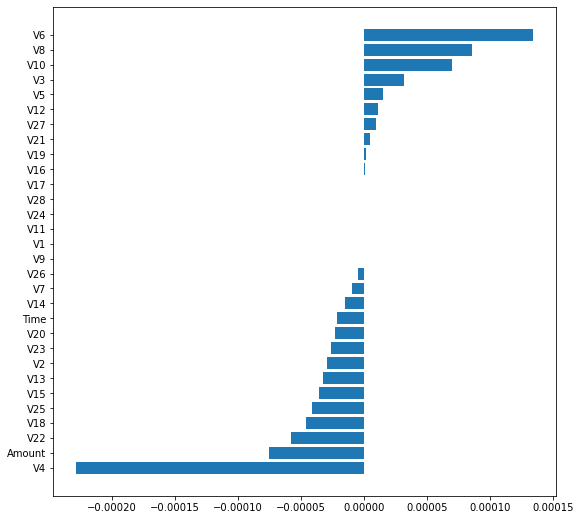

In [137]:
import matplotlib.pyplot as plt
features = []
scores = []
for k in explanation.explanations[0].attributions[0].feature_attributions:
    features.append(k)
    scores.append(explanation.explanations[0].attributions[0].feature_attributions[k])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)
fig, ax = plt.subplots()
fig.set_size_inches(9, 9)
ax.barh(features, scores)
fig.show()

---
## Batch Predictions: BigQuery Source to BigQuery Destination, with Explanations

In [ ]:
batch = aiplatform.BatchPredictionJob.create(
    job_display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    model_name = endpoint.list_models()[0].model,
    instances_format = "bigquery",
    predictions_format = "bigquery",
    bigquery_source = f'bq://{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped',
    bigquery_destination_prefix = f"{PROJECT_ID}",
    generate_explanation=True,
    labels = {'notebook':f'{NOTEBOOK}'}
)

INFO:google.cloud.aiplatform.jobs:Creating BatchPredictionJob
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob created. Resource name: projects/691911073727/locations/us-central1/batchPredictionJobs/5522655591295614976
INFO:google.cloud.aiplatform.jobs:To use this BatchPredictionJob in another session:
INFO:google.cloud.aiplatform.jobs:bpj = aiplatform.BatchPredictionJob('projects/691911073727/locations/us-central1/batchPredictionJobs/5522655591295614976')
INFO:google.cloud.aiplatform.jobs:View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/batch-predictions/5522655591295614976?project=691911073727
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/691911073727/locations/us-central1/batchPredictionJobs/5522655591295614976 current state:
JobState.JOB_STATE_RUNNING
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/691911073727/locations/us-central1/batchPredictionJobs/5522655591295614976 current state:
JobState.JOB_STAT

---
## Remove Resources
see notebook "99 - Cleanup"